# Introduction

---
[This notebook](https://www.kaggle.com/alexs2020/bert-1024-and-distilbert-comparison) shows my approach for the classification of desaster tweets regarding the [NLP Twitter kaggle challange]( https://www.kaggle.com/c/nlp-getting-started/overview).

My initial idea was to compare several BERT implementations with each other ([BERT Uncased 1024](https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2), [BERT Uncased 768](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2), [DistilBERT](https://huggingface.co/distilbert-base-uncased)) to get a feeling how well they performe given the task of the kaggle challange. For this, reasearch was done by getting used to the [BERT paper](https://arxiv.org/pdf/1810.04805v2.pdf) to understand the basic foundations of the algorithm as well as the tokenizer. This [colab notebook ](https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=q1InADgf5xm2) which is trying to visualize some things was a great inspiration and helped a lot to setup my initial notebook.

---
This notebook is seperated into different sections, relating to the common data science workflow (except the hypothesis and data collection where already done). 

1.   Setup and Check Infrastructure
2.   Having a first look at the Data (EDA)
3.   Helper Functions for Data Cleaning
4.   Data Cleaning (Feature Engineering)
5.   Pre-trained Bert Uncased model 1024 (& 768) (Model building 1/2)
6.   Pre-trained DistilBert model ((Model building 2/2)
7.   Showing Confusion Matrices for BERT models (to compare / evaluate)

---


## Approach:

I started with common values mentioned in different notebooks on kaggle (see inspiration in first section) to get a feeling what influences what and how does it generelly work. After gaining some experience I combined several approaches from the notebooks and general information from the internet. The most promising was one relatively at the beginning with a kaggle score of 84.247% (userID: AlexS2020, rank: 116 at 14.09.2020). This involved a relatively simple notebook running on kaggle, using the parameters mentioned in the list in section 5. It was not possible for me to beat this afterwards, although I tried a lot of different ways and optimizations (added apprevations, cleaned only partly, left links in the tweets, emojis, ...).

## Evaluation:
As will be mentioned in the last section, I used to compare the different val_acc and loss values of different models as well as uploading the submission files to get a direct comperision via the score. Last step to evaluate are the confusion_matrices to see how many false positive/negative and true postivie/negative.

## Conclusion:
Overall it was an interesting project / competition which enabled me to learn new stuff and try out several tools. It is interesting to see, that the lightweight DistilBERT model is relatively competitive to the way larger BERT 1024 model and the scores do not differ that much. This gets even more interesting when comparing the runtime the 1024 model needs in an equal setup 1458 seconds per epoche, the DistilBERT just 248 seconds (with almost same results after one epoche, see the confusion matrices)!

Last learning for today: DistilBERT tends to overfit when using higher learning rates and more epochs way faster then the BERT 1024 model.

## Outlook:
There are several ways how to improve these scores from my point of view. Some of them can be seen in other notebooks already (especially the larger ones).

1.   Run the notebook on larger hardware to play around with larger batch_sizes>16 and larger len_max>160.
2.   Adding dropouts to fight the overfitting
3.   Using different models behind each other as mentioned in the BERT paper to optimize output
4.   Modify the uncased model of BERT with more/different layers and play around with different activation functions, here for example: https://www.kaggle.com/sokolheavy/multi-dropout-aug-oof
5.   Write a script on local machine running different learning rates and other parameters so that different optimas can be found. 
6.   An adaptive learning rate could also help with optimizing the results

## Limitations:
- Some of the points mentioned in Outlook were not possible since running code in browser + only 36h GPU-time per week is hardly enough
- Automation of parameter search not feasible
- Getting OOR erros quite offen due to limited GPU storage (its quite big for free use case, still...)

---

So we beginn here with a short description of the data files, followed by the some general inspiration links which helped at different stages throughout the dev process. At some points I also used functions from these repos to optimize my own code.

## References:
Inspirations for implementation and design: 
- https://www.kaggle.com/c/nlp-getting-started/notebooks
- https://www.kaggle.com/bryanafreeman/disaster-tweets-with-nlp
- https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
- https://www.kaggle.com/choubane/lstm-for-disaster-tweets-80-validation-accuracy
- https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=q1InADgf5xm2

I hope you enjoy going through my first kaggle notebook, if there are any questions or proposals how to do stuff better - please let me know!

---

## Data description
Files

    train.csv - the training set
    test.csv - the test set
    sample_submission.csv - a sample submission file in the correct format

Columns

    id - a unique identifier for each tweet
    text - the text of the tweet
    location - the location the tweet was sent from (may be blank)
    keyword - a particular keyword from the tweet (may be blank)
    target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


# Setup & Check Infrastructure

The first step is to get the infrastructure up and running. Important to mention here is that it is strongly recommended to use a GPU for calculation purpose. Next step in this section is to install the needed tools (for DistilBERT and tokenizer) and to import all needed librarys I used at some point in this project.

Checking if GPU is enabled, CPU will take way longer. Should say at least "1"

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Installing transformer needed for encoding (BERT)

In [2]:
## Had some problems here with unknown errors corresponding to DistilBERT as mentioned here: https://github.com/huggingface/transformers/issues/1829
# !pip install transformers
## ... so installed from source
!pip install git+https://github.com/huggingface/transformers

import transformers

# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
    
import tokenization

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-4hm89ef5
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-4hm89ef5
     |████████████████████████████████| 3.0MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 24.4MB/s 
     |████████████████████████████████| 890kB 32.1MB/s 
  Created wheel for transformers: filename=transformers-3.1.0-cp36-none-any.whl size=962665 sha256=edc885d07823edb4865285b11fbb61cc0ea38170599bc9a832f674905b738e70
  Stored in directory: /tmp/pip-ephem-wheel-cache-jly16t98/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=23544ac9467b78b1d6d3d2bce44cf68553274b4cc2fbf4228f3a814f857170ea
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built transformers sacremoses


Import Librarys for data visualization, data cleaning and ML models

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import urllib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Here the data is loaded for easy access in the project. These paths have to be manipulated if running in colab.

Printing the shapes to get a feeling for the structure before jumping into the next section.

In [4]:
train_data = pd.read_csv("/home/train.csv")
test_data = pd.read_csv("/home/test.csv")
sample_sub = pd.read_csv("/home/sample_submission.csv")

#train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
#test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
#sample_sub = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
print('Train data shape: {}'.format(train_data.shape))
print('Test data shape: {}'.format(test_data.shape))
print('Sample submission shape: {}'.format(sample_sub.shape))

Train data shape: (7613, 5)
Test data shape: (3263, 4)
Sample submission shape: (3263, 2)


# Having a first look at the Data (EDA)

Before we can train something which classifies the phrases we first have to take a look what data we have available. An important part is to check whether there is an unacceptable difference between the different labeled groups. Afterwards we do the regular checking of NaNs and then visualizing the word counts in the tweets. 

In [5]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Checking how many true (1) and false (0) desaster tweets are in the set. Looks fairly distributed so no hustle due to an imbalanced dataset needed here.

([<matplotlib.patches.Wedge at 0x7f824be9b630>,
 [Text(-1.0732513534192263, -0.24110481617711227, 'Disaster'),
  Text(1.0732513534192263, 0.2411048161771121, 'Non-Disaster')],
 [Text(-0.5854098291377597, -0.1315117179147885, '57.0%'),
  Text(0.5854098291377597, 0.1315117179147884, '43.0%')])

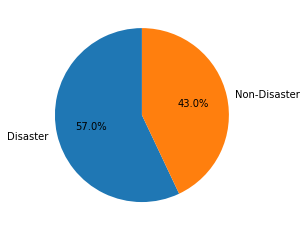

In [6]:
label = 'Disaster', 'Non-Disaster'
data = train_data.target.value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(data, labels=label,  startangle=90, autopct='%1.1f%%')

In [7]:
train_data.target.value_counts() #Label counts

0    4342
1    3271
Name: target, dtype: int64

Having a look at the data and how often NaN shows up. Its obvious that location misses in around a third of the tweets, keywords are only rarely missing.

In [8]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Checking the number of characters showing up per tweet in the two groups. They look pretty much alike, no huge discrepancy visible. A lot of Tweets seem to be in the range of 100 - 140 characters.

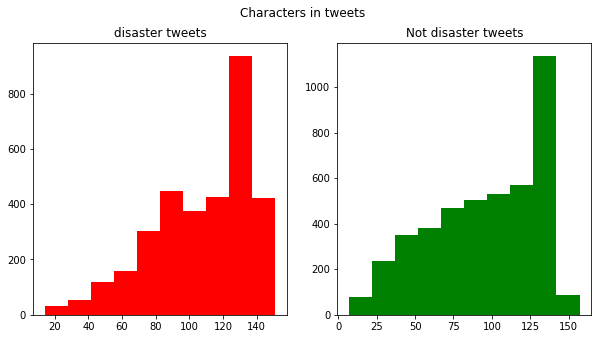

In [9]:
## Adopted from https://www.kaggle.com/sagar7390/nlp-on-disaster-tweets-eda-glove-bert-using-tfhub/comments#data
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_data[train_data['target']==1]['text'].str.len()
ax1.hist(tweet_len, color='red')
ax1.set_title('disaster tweets')
tweet_len=train_data[train_data['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

# Helper functions

As pictured in the above list there is a lot of information in these tweets which is potentially not relevant for our classification task. In order to optimize our runtime and to focuse on the important information we have to filter the tweets. This will be done in the next section EDA 2/2.

Cleaning and exchanging abbreviations, links, smileys.

In [10]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [11]:
def clean_tweets(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    html=re.compile(r'<.*?>')
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    table=str.maketrans('','',string.punctuation)
    
    text = url.sub(r'',text)
    text = html.sub(r'',text)
    text = emoji_pattern.sub(r'', text)
    text = text.translate(table)

    return text

# Data Cleaning (Feature engineering)

Before being able to start with the classification, the data must be cleaned up and transferred into a proper structure (tokenization) so that the classifier is able to handle the tweets.

---

In the tweets there are many different special characters and links, which should be removed at the beginning since the take calculation power and do not add value to the classification. I combined several cleanings in the helper functions to keep the lambda function calls as clean as possible.

Also tried different versions as mentioned in the next section with cleaning only specific things up (in example links, tags, emojis) or just cleaning the train data, not the test data. Overall, it worked better with the functions in place.

In [13]:
test_data.head

<bound method NDFrame.head of          id keyword location                                               text
0         0     NaN      NaN                 Just happened a terrible car crash
1         2     NaN      NaN  Heard about #earthquake is different cities, s...
2         3     NaN      NaN  there is a forest fire at spot pond, geese are...
3         9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4        11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
...     ...     ...      ...                                                ...
3258  10861     NaN      NaN  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259  10865     NaN      NaN  Storm in RI worse than last hurricane. My city...
3260  10868     NaN      NaN  Green Line derailment in Chicago http://t.co/U...
3261  10874     NaN      NaN  MEG issues Hazardous Weather Outlook (HWO) htt...
3262  10875     NaN      NaN  #CityofCalgary has activated its Municipal Eme...

[3263 row

In [14]:
sample_sub.head

<bound method NDFrame.head of          id  target
0         0       0
1         2       0
2         3       0
3         9       0
4        11       0
...     ...     ...
3258  10861       0
3259  10865       0
3260  10868       0
3261  10874       0
3262  10875       0

[3263 rows x 2 columns]>

In [15]:
%%time
train_data['text']=train_data['text'].apply(lambda x : clean_tweets(x))
test_data['text']=test_data['text'].apply(lambda x : clean_tweets(x))

test_data['text']=test_data['text'].apply(lambda x : convert_abbrev_in_text(x))
train_data['text']=train_data['text'].apply(lambda x : convert_abbrev_in_text(x))

CPU times: user 1.77 s, sys: 3.77 ms, total: 1.77 s
Wall time: 1.78 s


# Pre-trained Bert Uncased model 1024 (& 768) (Model building 1/2)

Loading different BERT models (english) and testing them. General takeaways:

In direct comparison between the 1024 and 768 model, the larger model was mostly more accurate, although it needed more time due to more learnable parameters (almost double the time). So for a slightly less accurate model you can safe almost half the training time, this can be especially relevant and interesting for less performaned hardware I would say.

This gets even more interesting when comparing against the DistilBERT model, the 1024 needs in an equal setup 1458 seconds per epoche, the DistilBERT just 248 seconds (with almost same results after one epoche, see the confusion matrices)!

Due to a coding error at the beginning of the project, the first trainings where always with a cleaned training dataset and an uncleaned test dataset. This error remained unnoticed for a while and eventually got solved. This point is stated clearly in the following list of scores and valuation_accuracys.

---

### **Default epoche=3 and max_len=160 of layers if not mentioned otherwise.**

Using the bert_en_uncased_L-24_H-1024_A-16/2 model:
  - batch_size=16, validation_split=0.2, max_sequence_length=512, lr=1e-5
  - batch_size=16, validation_split=0.2, max_sequence_length=512, lr=6e-6 -> seems to overfit when using over 5 epochs (val_acc decreases slightly or stagnates, val_acc 11 % gap compared to acc), best result with 4 epochs
  - batch_size=8, validation_split=0.2, max_sequence_length=512, lr=6e-6, epochs=5 -> score: 84.247 --- **best score yet** ---
  - batch_size=16, validation_split=0.2, max_sequence_length=100, lr=2e-5, decay = 0.01 -> val_acc looks good, only 2% discrepancy to acc in second epoche, 4% in third -> score: 83.30%
  - batch_size=16, validation_split=0.2, max_sequence_length=320, lr=2e-5, decay = 0.01 -> val_acc looks good, only 2% discrepancy to acc in second epoche, 4% in third -> score: 83.38%
  - batch_size=16, validation_split=0.2, max_sequence_length=512, lr=2e-5, decay = 0.01 -> val_acc 84.31, only 4% discrepancy to acc in third epoche -> score: 83.879%
  - batch_size=16, validation_split=0.2, max_sequence_length=512, lr=6e-6, decay = 0.01 -> val_acc 83.39% -> score: 81.795
  - batch_size=16, validation_split=0.2, max_sequence_length=512, lr=6e-6, decay = 0.01, test_size=0.2 -> val_acc 83.91% -> score: 82.19%
  - batch_size=16, validation_split=0.2, max_sequence_length=512, lr=1e-6, decay = 0.01, test_size=0.2, epochs=5 -> val_acc 83.13% -> score: 81.520%

Without clean_tweets and abbrevations:
  - batch_size=16, validation_split=0.2, max_sequence_length=512, lr=2e-5 -> val_acc 81.62% -> score: 83.512%

With abbrevations without clean_tweets:
  - batch_size=8, validation_split=0.2, max_sequence_length=512, lr=6e-6 -> val_acc 83.45% -> score: 83.634%

---
Using the bert_en_uncased_L-12_H-768_A-12/2 model:
  - batch_size=16, validation_split=0.2, max_lemax_sequence_lengthngth=512, lr=2e-5, decay = 0.01 -> val_acc=82.99% -> score=82.42% (overfitting)
  - batch_size=32, validation_split=0.2, max_sequence_length=512, lr=2e-5, decay = 0.01 -> val_acc=82.80% -> score=82.35% (overfitting)


Parameters for BERT model:

In [16]:
dropout_num=0
max_length=160
max_sequence_length=512
learning_rate_BERT=1e-6
val_split_BERT=0.2
epochs_BERT=1
batch_size_BERT=8


---
**There was an error while cleaning the data so only the train data was cleaned, not the test data. This has with high probability falsified the values of the following runs:**

---

**Using the bert_en_uncased_L-24_H-1024_A-16/2 model (without cleaning the test data):**  
  - batch_size=16, validation_split=0.2, max_sequence_length=512, lr=6e-6, decay = 0.01, test_size=0.2 -> val_acc 83.45% -> score: 82.439%
  - batch_size=16, validation_split=0.3, max_sequence_length=512, lr=1e-6, test_size=0.2, epoche=3 -> val_acc 82.67% 
  - batch_size=16, validation_split=0.3, max_sequence_length=512, lr=1e-6, test_size=0.2, epoche=5 -> val_acc 82.31% 
  - batch_size=8, validation_split=0.2, max_sequence_length=512, lr=6e-6, test_size=0.2, epoche=5 -> val_acc 83.26% -> score: 81.703% 
  - batch_size=16, validation_split=0.2, max_sequence_length=512, lr=2e-5 -> val_acc 83.32% -> score: 82.960%
  - batch_size=8, validation_split=0.2, max_sequence_length=160, lr=2e-5 -> val_acc 83.06% -> score: 82.776%


--- 

Not running on kaggle using 1024 model: Everythin over batch_size>16 when max_sequence_length is over 100

---


Dropouts got mostly OOM errors. On bigger hardware it would be good to play around with it.

Played around with different learning rates, going from 1e-5 to 6e-6, some of them did not converge in the given epochs or got OOMs.

---

In [17]:
# Adopted with max_len placeholder for easy parameter manipulation from https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
def bert_encode(texts, tokenizer, max_len=max_sequence_length):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [18]:
# Adopted with dropout_num, learning_rate and max_len placeholders for easy parameter manipulation from https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
def build_model(bert_layer, Dropout_num=dropout_num, max_len=max_sequence_length):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if Dropout_num == 0:
        # Without Dropout
        out = Dense(1, activation='sigmoid')(clf_output)
    else:
        # With Dropout(Dropout_num), Dropout_num > 0
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate_BERT), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

---
Running into allocation errors here all the time so had to try different options
- OOM (out of Memory) when allocating tensor with shape[16,16,64,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

Major problem seems to be batch_size=16 with max_sequence_length=512 which is to high for colab with a validation split of 0.2. GPU storage is full then. This can partly be resolved when developing on kaggle since the following setups are running smothly when not on colab:


Relating threads: 
- https://www.kaggle.com/c/tensorflow2-question-answering/discussion/118868
- https://stackoverflow.com/questions/59617755/training-a-bert-based-model-causes-an-outofmemory-error-how-do-i-fix-this
- https://stackoverflow.com/questions/50760543/error-oom-when-allocating-tensor-with-shape/50764934

---

In [19]:
%%time
##module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2'.
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2: 777.11MB
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2, Total size: 1.26GB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2'.


CPU times: user 23.8 s, sys: 5.21 s, total: 29 s
Wall time: 40.7 s


In [20]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [21]:
# Adopted the max_len with placeholders from https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert?scriptVersionId=42583022
train_input = bert_encode(train_data.text.values, tokenizer, max_length)
test_input = bert_encode(test_data.text.values, tokenizer, max_length)
train_labels = train_data.target.values

Building the model with given Shape as stated in the summary below. When shape is to large, OOM is thrown.

In [22]:
model_BERT_1024 = build_model(bert_layer, max_len=max_length)
model_BERT_1024.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

This is where the real training/finetuning of the pretrained model happens, everything with placeholder so they can all be manipulated at the start of this section without jumping around in the code.

In [23]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history_1024 = model_BERT_1024.fit(
    train_input, train_labels,
    validation_split=val_split_BERT,
    epochs=epochs_BERT,
    callbacks=[checkpoint],
    batch_size=batch_size_BERT
)

762/762 [==============================] - 1458s 2s/step - loss: 0.5343 - accuracy: 0.7379 - val_loss: 0.4311 - val_accuracy: 0.8070


Predicting (classifying) the test tweets with the pretrained and finetuned model.

In [25]:
%%time
model_BERT_1024.load_weights('model.h5')
test_pred = model_BERT_1024.predict(test_input)

CPU times: user 37 s, sys: 30 s, total: 1min 7s
Wall time: 4min 7s


In [26]:
# Thanks to https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert?scriptVersionId=42583022
# Prediction by BERT model with my tuning for the training data - for the Confusion Matrix
%%time
train_pred_BERT = model_BERT_1024.predict(train_input)
train_pred_BERT_int = train_pred_BERT.round().astype('int')

CPU times: user 1min 20s, sys: 1min 7s, total: 2min 27s
Wall time: 8min 7s


Saving the prediction to the submission file - probably most important step of this notebook...

In [27]:
sample_sub['target'] = test_pred.round().astype(int)
sample_sub.to_csv("./submission.csv", index=False, header=True)

In [28]:
check_sample = pd.read_csv("./submission.csv")
check_sample.head(20)

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


# Pre-trained DistilBERT model (Model building 2/2) and comparison

This is a good evaluation model to test against the BERT 1024 one, since it is more lightweight then the other two BERT models, optimized for low performance hardware. Most of the comments/explanations from the section beforehand apply and are not listed again.

---

**Example 1 comparison with same parameters:**
* dropout_num=0
* max_length=160
* max_sequence_length=512
* learning_rate_BERT=2e-6
* val_split_BERT=0.2
* epochs_BERT=3
* batch_size_BERT=8


**BERT 1024 score: 82.837 % running appr. 18 min for 3 epoches**

**DistilBERT score: 82.224 % running appr. 4 min for 3 epoches**

---

**Example 2 comparison with same parameters:**
* dropout_num=0
* max_length=160
* max_sequence_length=512
* learning_rate_BERT=1e-5
* val_split_BERT=0.2
* epochs_BERT=5
* batch_size_BERT=8

**BERT 1024 score: 83.910 % running appr. 35 min for 5 epoches**

**DistilBERT score: 81.336 % running appr. 7 min for 5 epoches**

---


**Example 3 comparison with same parameters:**
- dropout_num=0
- max_length=160
- max_sequence_length=512
- learning_rate_BERT=6e-6
- val_split_BERT=0.2
- epochs_BERT=5
- batch_size_BERT=8

**BERT 1024: 421s 553ms/step - loss: 0.1136 - accuracy: 0.9585 - val_loss: 0.6983 - val_accuracy: 0.7905**

**DistilBERT: 89s 117ms/step - loss: 0.1950 - accuracy: 0.9286 - val_loss: 0.5285 - val_accuracy: 0.8142**


In [29]:
# For DistilBERT:
## https://www.kaggle.com/xhlulu/disaster-nlp-distilbert-in-tf

%%time
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer_DistilBERT = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.



CPU times: user 7.07 s, sys: 1.42 s, total: 8.5 s
Wall time: 12.6 s


In [30]:
def build_model_DistilBERT(transformer, max_len=max_sequence_length):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=learning_rate_BERT), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [31]:
model_DistilBERT = build_model_DistilBERT(transformer_layer, max_len=max_length)
model_DistilBERT.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 160)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 160, 768),)       66362880  
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 769       
Total params: 66,363,649
Trainable params: 66,363,649
Non-trainable params: 0
_________________________________________________________________


In [32]:
train_input_DistilBERT = bert_encode(train_data.text.values, tokenizer_DistilBERT, max_len=160)
test_input_DistilBERT = bert_encode(test_data.text.values, tokenizer_DistilBERT, max_len=160)
train_labels_DistilBERT = train_data.target.values

In [33]:
train_history_DistilBERT = model_DistilBERT.fit(
    train_input, train_labels,
    validation_split=val_split_BERT,
    epochs=epochs_BERT,
    batch_size=batch_size_BERT
)

762/762 [==============================] - 248s 326ms/step - loss: 0.5579 - accuracy: 0.7130 - val_loss: 0.4439 - val_accuracy: 0.8070


In [34]:
%%time
test_pred_DistilBERT = model_DistilBERT.predict(test_input_DistilBERT, verbose=1)

102/102 [==============================] - 32s 314ms/step
CPU times: user 6.47 s, sys: 2.39 s, total: 8.86 s
Wall time: 33.9 s


In [35]:
# Thanks to https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert?scriptVersionId=42583022
# Prediction by BERT model with my tuning for the training data - for the Confusion Matrix
%%time
train_pred_DistilBERT = model_DistilBERT.predict(train_input_DistilBERT)
train_pred_DistilBERT_int = train_pred_DistilBERT.round().astype('int')

CPU times: user 10.1 s, sys: 4.53 s, total: 14.6 s
Wall time: 1min 15s


In [36]:
sample_sub['target'] = test_pred_DistilBERT.round().astype(int)
sample_sub.to_csv('submission_DistilBERT.csv', index=False, header=True)

check_sample_DistilBERT = pd.read_csv("./submission_DistilBERT.csv")
check_sample_DistilBERT.head(20)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


# Showing Confusion Matrices for BERT models (to compare)

The scores are not bad to test different models against each other but since it is only possible to upload 5 submissions a day it is not sufficient when running several projects/models. I also compared the val_acc and loss numbers with each other to get a better understanding but what really helps in my opinion are these model confusion matrices when displayed next to each other.

In [37]:
# Showing Confusion Matrix, thanks to https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert?scriptVersionId=42583022
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

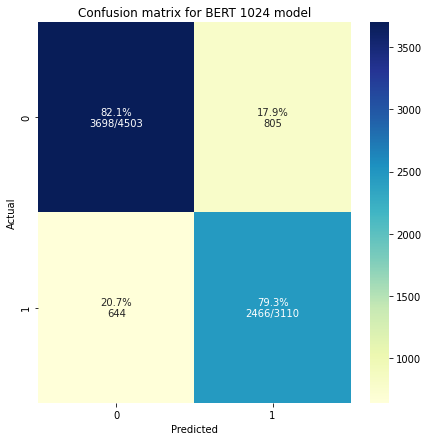

In [38]:
# Showing Confusion Matrix for BERT model
plot_cm(train_pred_BERT_int, train_data['target'].values, 'Confusion matrix for BERT 1024 model', figsize=(7,7))

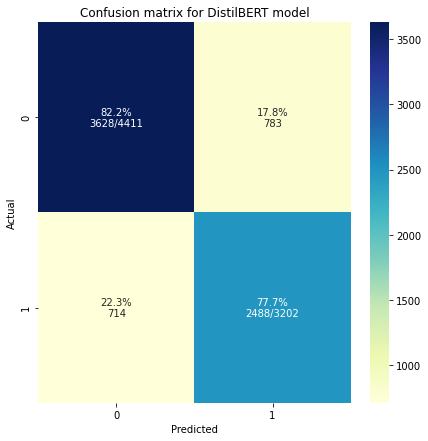

In [39]:
# Showing Confusion Matrix for BERT model
plot_cm(train_pred_DistilBERT_int, train_data['target'].values, 'Confusion matrix for DistilBERT model', figsize=(7,7))

As you can see in the confusion matrices, it is almost identical for one epoche. Slight differences can be seen in the false positive/negative with the BERT 1024 model being supperior.

---

When running trainings with larger epochs (3-5) it is very clear that the DistilBERT has less error rates on the training data and overfits slightly more than the larger models. This effects intensivies when largening the learning rate ...

---